In [18]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from PIL import Image
import clip
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COCO_PATH = Path(r"C:\Users\barta\Documents\cours\iaprojets\PDR\code\datasets\coco\train2017\train2017")  
SHIFT_VALUES = list(range(1,3))  
NUM_IMAGES = 2

print(f"Device utilisé: {DEVICE}")

Device utilisé: cuda


Test: Original shape (428, 640, 3), Encrypted shape (428, 640, 3)


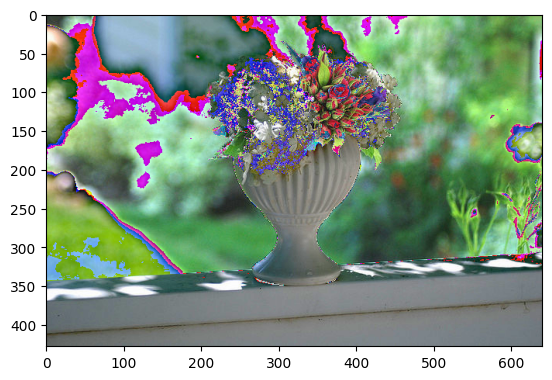

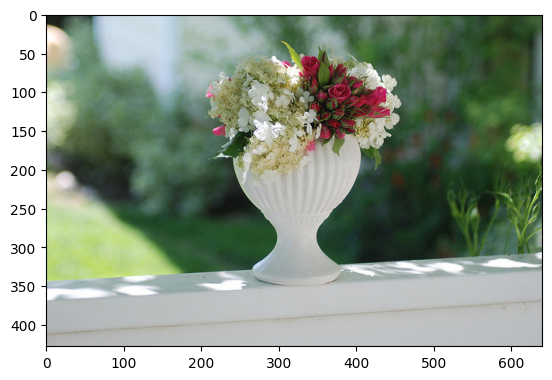

In [20]:
def encrypt_image_bitshift(image_array, shift):
    """
    Chiffre une image en décalant les bits.
    
    Args:
        image_array: np.array de forme (H, W, 3) avec valeurs 0-255
        shift: int entre 0 et 8
            - 0: aucun changement
            - 8: tous les bits à 0 (chiffrement total)
    
    Returns:
        Image chiffrée (np.array)
    """
    if shift == 0:
        return image_array.copy()
    elif shift == 8:
        return np.zeros_like(image_array)
    else:
        encrypted = image_array << shift
        return encrypted.astype(np.uint8)

# Test rapide
test_img = np.array(Image.open(list(COCO_PATH.glob("*.jpg"))[2]).convert('RGB'))
test_enc = encrypt_image_bitshift(np.array(test_img), 1)
print(f"Test: Original shape {test_img.shape}, Encrypted shape {test_enc.shape}")
plt.imshow(test_enc)
plt.show()
plt.imshow(test_img)
plt.show()

Test: Original shape (428, 640, 3), Encrypted shape (428, 640, 3)


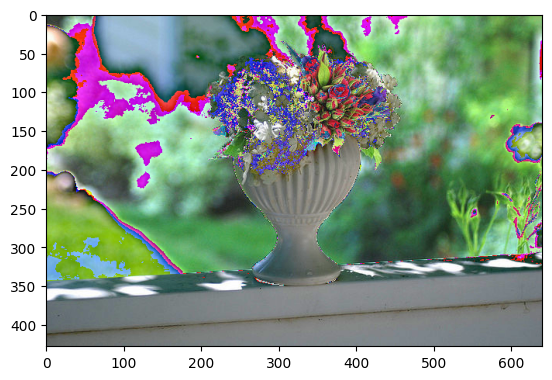

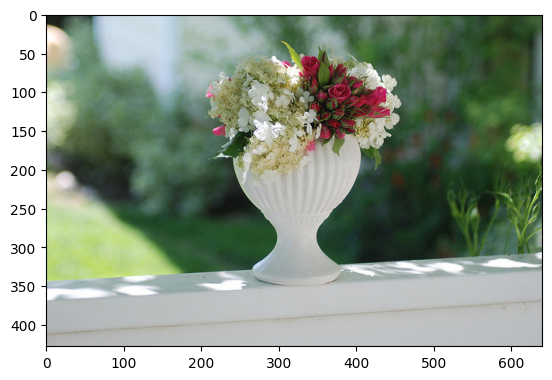

In [21]:
import numpy as np
from numba import njit

# ---------------------------------------------------------
# 1. CHIFFREMENT (Version Numba ultra-rapide)
# ---------------------------------------------------------
@njit
def encrypt_image_bitshift_fast(img_array, shift):
    """
    Applique le bitshift circulaire sur une image (H, W, 3).
    Equivalent à la version C.
    """
    # Aplatir pour traiter comme un long flux de pixels
    flat = img_array.ravel()
    out = np.empty_like(flat)
    
    # S'assurer que le shift est modulo 8
    s = shift % 8
    inv_s = 8 - s
    
    for i in range(flat.size):
        val = flat[i]
        # Opération binaire (Bitwise)
        # On doit caster en uint8 pour être sûr du comportement
        out[i] = (val << s) | (val >> inv_s)
        
    return out.reshape(img_array.shape)
# Test rapide
test_img = np.array(Image.open(list(COCO_PATH.glob("*.jpg"))[2]).convert('RGB'))
test_enc = encrypt_image_bitshift_fast(np.array(test_img), 1)
print(f"Test: Original shape {test_img.shape}, Encrypted shape {test_enc.shape}")
plt.imshow(test_enc)
plt.show()
plt.imshow(test_img)
plt.show()

In [22]:

# ---------------------------------------------------------
# 2. ENTROPIE (Version Numba)
# ---------------------------------------------------------
@njit
def compute_entropy_fast(img_array):
    flat = img_array.ravel()
    
    # Histogramme manuel (très rapide en compilé)
    hist = np.zeros(256, dtype=np.int64)
    for i in range(flat.size):
        hist[flat[i]] += 1
    
    # Calcul Entropie
    entropy = 0.0
    size = flat.size
    for i in range(256):
        if hist[i] > 0:
            p = hist[i] / size
            entropy -= p * np.log(p)
            
    return entropy
# Test
test_entropy = compute_entropy_fast(test_img)
print(f"Entropie test: {test_entropy:.4f} bits")

Entropie test: 5.2363 bits


In [23]:
def compute_pixel_entropy(image_array):
    """
    Calcule l'entropie de Shannon des pixels d'une image.
    
    Args:
        image_array: np.array de forme (H, W, 3)
    
    Returns:
        float: entropie moyenne sur les 3 canaux
    """
    entropies = []
    
    for channel in range(3):
        # Histogramme du canal
        hist, _ = np.histogram(image_array[:, :, channel], bins=256, range=(0, 256))
        # Normalisation pour obtenir une distribution de probabilité
        prob_dist = hist / hist.sum()
        # Calcul de l'entropie (en bits)
        ent = entropy(prob_dist)
        entropies.append(ent)
    
    return np.mean(entropies)

# Test
test_entropy = compute_pixel_entropy(test_img)
print(f"Entropie test: {test_entropy:.4f} bits")

Entropie test: 5.1874 bits


In [24]:

# ---------------------------------------------------------
# 3. MI HISTOGRAMME (Version Numba)
# ---------------------------------------------------------
@njit
def compute_mi_hist_fast(img1, img2):
    flat1 = img1.ravel()
    flat2 = img2.ravel()
    size = flat1.size
    
    # Histogrammes conjoints (Joint 256x256)
    joint_hist = np.zeros((256, 256), dtype=np.int32)
    hist1 = np.zeros(256, dtype=np.int32)
    hist2 = np.zeros(256, dtype=np.int32)
    
    # Une seule passe pour tout remplir
    for i in range(size):
        u = flat1[i]
        v = flat2[i]
        joint_hist[u, v] += 1
        hist1[u] += 1
        hist2[v] += 1
        
    # Calcul MI
    mi = 0.0
    for u in range(256):
        for v in range(256):
            if joint_hist[u, v] > 0:
                p_uv = joint_hist[u, v] / size
                p_u = hist1[u] / size
                p_v = hist2[v] / size
                mi += p_uv * np.log(p_uv / (p_u * p_v))
                
    return mi
# Test
test_mi = compute_mi_hist_fast(test_img, test_enc)
print(f"MI histogramme test: {test_mi:.4f}")

MI histogramme test: 5.2363


In [25]:
def compute_mi_histogram(img1, img2, bins=256):
    """
    Calcule l'information mutuelle entre deux images par histogrammes.
    
    Args:
        img1, img2: np.array de forme (H, W, 3)
        bins: nombre de bins pour l'histogramme
    
    Returns:
        float: information mutuelle moyenne sur les 3 canaux
    """
    mi_values = []
    
    for channel in range(3):
        # Aplatir les canaux
        c1 = img1[:, :, channel].flatten()
        c2 = img2[:, :, channel].flatten()
        
        # Calculer l'IM avec sklearn
        mi = mutual_info_score(c1, c2)
        mi_values.append(mi)
    
    return np.mean(mi_values)

# Test
test_mi = compute_mi_histogram(test_img, test_enc)
print(f"MI histogramme test: {test_mi:.4f}")

MI histogramme test: 5.1874


In [26]:
# Charger CLIP
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
model.eval()

print("Modèle CLIP chargé avec succès")
print(f"Preprocessing: {preprocess}")

Modèle CLIP chargé avec succès
Preprocessing: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000002055579E0C0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [27]:
def get_clip_embedding(image_array):
    """
    Extrait l'embedding CLIP d'une image.
    
    Args:
        image_array: np.array de forme (H, W, 3) avec valeurs 0-255
    
    Returns:
        np.array: vecteur d'embedding de dimension 512
    """
    # Convertir en PIL Image
    pil_image = Image.fromarray(image_array)
    
    # Prétraitement CLIP
    image_input = preprocess(pil_image).unsqueeze(0).to(DEVICE)
    
    # Extraction de l'embedding
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        # Normalisation
        image_features /= image_features.norm(dim=-1, keepdim=True)
    
    return image_features.cpu().numpy().flatten()

# Test
test_embedding = get_clip_embedding(test_img)
print(f"Embedding shape: {test_embedding.shape}")

Embedding shape: (512,)


In [28]:
def process_single_image(image_path, shift_values):
    """
    Traite une image pour tous les shifts et calcule les métriques.
    
    Args:
        image_path: Path vers l'image
        shift_values: liste des valeurs de shift à tester
    
    Returns:
        dict contenant toutes les métriques
    """
    # Charger l'image
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    
    # Embedding original
    emb_orig = get_clip_embedding(img_array)
    
    # Entropie originale
    entropy_orig = compute_entropy_fast(img_array)
    
    results = []
    
    for shift in shift_values:
        # Chiffrement
        img_encrypted = encrypt_image_bitshift_fast(img_array, shift)
        
        # Embedding chiffré
        emb_enc = get_clip_embedding(img_encrypted)
        
        # IM par histogrammes
        mi_hist = compute_mi_histogram(img_array, img_encrypted)
        
        # Préparer données pour MINE
        df_embeddings = pd.DataFrame({
            'dim_val_orig': emb_orig,
            'dim_val_chiff': emb_enc
        })
        
        results.append({
            'image_path': str(image_path),
            'shift': shift,
            'entropy_original': entropy_orig,
            'mi_histogram': mi_hist,
            'embeddings_df': df_embeddings,
            'embedding_orig': emb_orig,
            'embedding_encrypted': emb_enc
        })
    
    return results

# Test sur une image
test_results = process_single_image(list(COCO_PATH.glob("*.jpg"))[0], [0, 4, 8])
print(f"Nombre de résultats: {len(test_results)}")

Nombre de résultats: 3


In [29]:
from torch_mist import estimate_mi

def compute_mine_mi(df_embeddings, device='cuda'):
    """
    Calcule l'information mutuelle via MINE.
    
    Args:
        df_embeddings: DataFrame avec colonnes 'dim_val_orig' et 'dim_val_chiff'
    
    Returns:
        float: valeur de MI ou np.nan en cas d'erreur
    """
    try:
        result, logs = estimate_mi(
            data=df_embeddings,              
            x_key='dim_val_orig',
            y_key='dim_val_chiff',
            estimator='mine',
            hidden_dims=[32, 16],
            batch_size=64,
            verbose=False,
            device=device,
            max_epochs=100
        )
        
        # MINE retourne un dict avec la clé 'I(dim_val_orig;dim_val_chiff)'
        mi_key = 'I(dim_val_orig;dim_val_chiff)'
        
        if isinstance(result, dict) and mi_key in result:
            return float(result[mi_key])
        else:
            print(f"Format de résultat inattendu: {result}")
            return np.nan
            
    except Exception as e:
        print(f"Erreur MINE: {e}")
        return np.nan

# Test
test_mine = compute_mine_mi(test_results[0]['embeddings_df'])
print(f"MI MINE: {test_mine}")

[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
MI MINE: 0.36248884350061417


In [30]:
'''
def main_analysis(num_images=NUM_IMAGES, output_path="results.csv"):
    """
    Analyse principale sur le dataset COCO.
    
    Args:
        num_images: nombre d'images à traiter
        output_path: chemin du fichier de résultats
    """
    # Récupérer les images
    image_paths = list(COCO_PATH.glob("*.jpg"))[75:75+num_images]
    
    all_results = []
    X_list = []          # Stockera les vecteurs (numpy arrays)
    labels_type = []     # "Original" ou "Chiffre"
    labels_shift = []
    labels_id = []  
    
    for i,img_path in enumerate(tqdm(image_paths, desc="Traitement des images")):
        try:
            # Traiter l'image pour tous les shifts
            img_results = process_single_image(img_path, SHIFT_VALUES)
            res = img_results[0]
            vec_orig = res['embedding_orig']
            X_list.append(vec_orig.flatten())
            labels_type.append("Original")
            labels_shift.append(0)
            labels_id.append(str(i))     # <--- On stocke le numéro de l'image (ex: "0")
            # Ajouter MINE pour chaque shift
            for res in img_results:
                vec_orig = res['embedding_orig']
                vec_enc = res['embedding_encrypted']
                shift_val = str(res['shift'])

                
                

                X_list.append(vec_enc.flatten())
                labels_type.append("Chiffre")
                labels_shift.append(shift_val)
                labels_id.append(str(i))     # <--- On stocke le numéro de l'image (ex: "0")

                mine_result = compute_mine_mi(res['embeddings_df'], device=DEVICE)
                
                # S'assurer que toutes les valeurs sont des scalaires
                all_results.append({
                    'image_path': str(res['image_path']),
                    'shift': int(res['shift']),
                    'entropy_original': float(res['entropy_original']),
                    'mi_histogram': float(res['mi_histogram']),
                    'mi_mine': float(mine_result) if not np.isnan(mine_result) else np.nan
                })
          
        except Exception as e:
            print(f"Erreur sur {img_path}: {e}")
            continue
    X = np.vstack(X_list)

    # Sauvegarder les résultats
    df_results = pd.DataFrame(all_results)
    
    # Vérifier les types de données
    print("Types de colonnes:")
    print(df_results.dtypes)
    
    df_results.to_csv(output_path, index=False)
    
    print(f"Résultats sauvegardés dans {output_path}")
    print(f"Nombre total de mesures: {len(df_results)}")
    
    return df_results,X,labels_type,labels_shift,labels_id

# Lancer l'analyse
df_final,X,labels_type,labels_shift,labels_id = main_analysis(num_images=NUM_IMAGES)
print(f"Forme finale de la matrice X : {X.shape}")

'''


'\ndef main_analysis(num_images=NUM_IMAGES, output_path="results.csv"):\n    """\n    Analyse principale sur le dataset COCO.\n\n    Args:\n        num_images: nombre d\'images à traiter\n        output_path: chemin du fichier de résultats\n    """\n    # Récupérer les images\n    image_paths = list(COCO_PATH.glob("*.jpg"))[75:75+num_images]\n\n    all_results = []\n    X_list = []          # Stockera les vecteurs (numpy arrays)\n    labels_type = []     # "Original" ou "Chiffre"\n    labels_shift = []\n    labels_id = []  \n\n    for i,img_path in enumerate(tqdm(image_paths, desc="Traitement des images")):\n        try:\n            # Traiter l\'image pour tous les shifts\n            img_results = process_single_image(img_path, SHIFT_VALUES)\n            res = img_results[0]\n            vec_orig = res[\'embedding_orig\']\n            X_list.append(vec_orig.flatten())\n            labels_type.append("Original")\n            labels_shift.append(0)\n            labels_id.append(str(i))

Traitement CLIP + MIST:   0%|          | 0/2 [00:00<?, ?it/s]

[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement CLIP + MIST:  50%|█████     | 1/2 [04:46<04:46, 286.45s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement CLIP + MIST: 100%|██████████| 2/2 [08:45<00:00, 262.62s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
Résultats sauvegardés dans results.csv

--- RÉSULTATS GLOBAUX ---
Entropie Moyenne H(X) des vecteurs CLIP: 6.1953


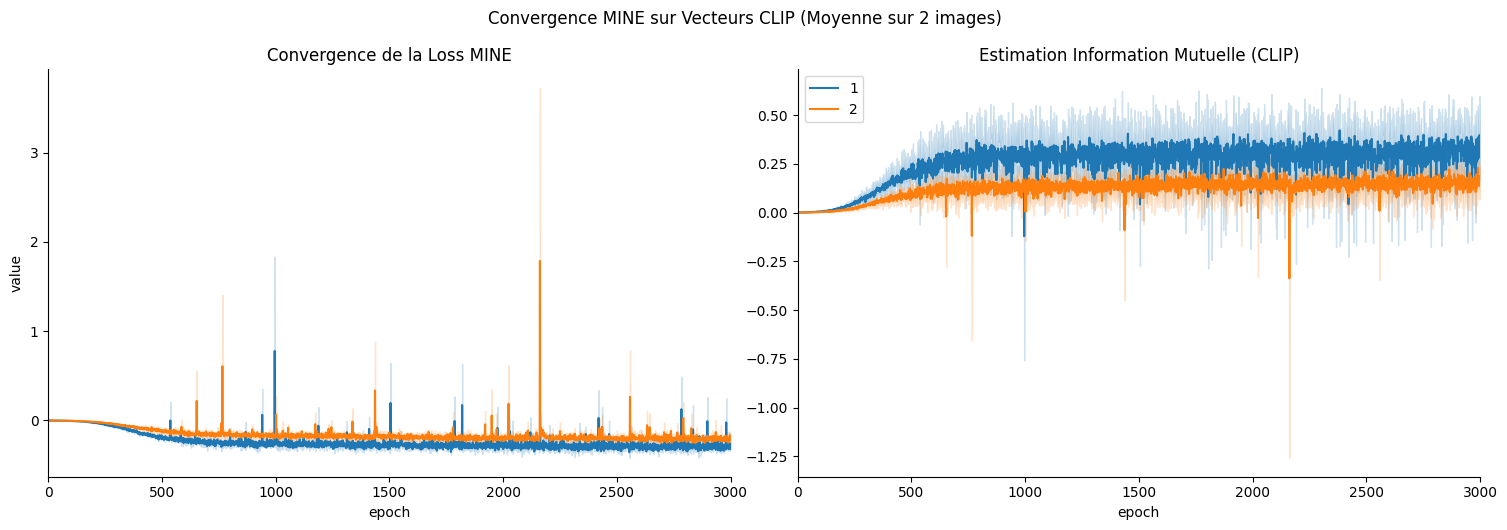

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import entropy
from torch_mist import estimate_mi # <--- Utilisation de la librairie MIST

def main_analysis(num_images=NUM_IMAGES, output_path="results.csv"):
    """
    Analyse avec vecteurs CLIP et estimation MINE via la librairie torch_mist.
    """
    # Récupérer les images
    image_paths = list(COCO_PATH.glob("*.jpg"))[75:75+num_images]
    
    all_results = []
    all_logs = []         # Pour stocker les historiques de loss (MIST)
    X_list = []           
    labels_type = []      
    labels_shift = []
    labels_id = []  
    
    # Pour la visualisation globale
    global_entropies = [] 

    for i, img_path in enumerate(tqdm(image_paths, desc="Traitement CLIP + MIST")):
        try:
            # Traiter l'image pour tous les shifts
            img_results = process_single_image(img_path, SHIFT_VALUES)
            
            # --- 1. Gestion de l'original pour t-SNE (Shift 0) ---
            res_orig = img_results[0]
            vec_orig = res_orig['embedding_orig'].flatten() # Vecteur CLIP (ex: 512 dims)
            
            X_list.append(vec_orig)
            labels_type.append("Original")
            labels_shift.append(0)
            labels_id.append(str(i))
            
            # Calcul de l'entropie "théorique" sur le vecteur original
            # Note: Sur des floats continus (CLIP), value_counts peut être inexact si pas d'arrondi,
            # mais on suit la logique de votre snippet.
            vec_orig_counts = pd.Series(vec_orig).value_counts()
            h_x = entropy(vec_orig_counts)
            global_entropies.append(h_x)

            # --- 2. Boucle sur les shifts (Chiffrement) ---
            for res in img_results:
                vec_enc = res['embedding_encrypted'].flatten()
                shift_val = str(res['shift'])

                # Stockage pour t-SNE
                X_list.append(vec_enc)
                labels_type.append("Chiffre")
                labels_shift.append(shift_val)
                labels_id.append(str(i))

                # --- PRÉPARATION MIST (DataFrame) ---
                # On traite les dimensions du vecteur comme des "samples" pour la distribution
                df_mist = pd.DataFrame({
                    'clip_original': vec_orig,
                    'clip_chiffre': vec_enc
                })

                # --- ESTIMATION MI (torch_mist) ---
                # Utilisation des paramètres de votre snippet
                mist_result, mist_logs = estimate_mi(
                    data=df_mist,
                    x_key='clip_original',
                    y_key='clip_chiffre',
                    estimator='mine',       # On utilise MINE
                    hidden_dims=[64, 64],   # Architecture légère pour vecteurs
                    batch_size=len(df_mist),# Full batch car le vecteur est petit (~512)
                    verbose=False,
                    device=DEVICE,          # 'cuda' ou 'cpu'
                    max_epochs=3000,        # Suffisant pour converger sur des petits vecteurs
                    early_stopping=True,
                    patience=20
                )

                # Récupération de la valeur MI
                # result est un dict {'mutual_information': value}
                mi_value = list(mist_result.values())[0]

                # Enrichissement des logs pour le graphique
                mist_logs['image_id'] = i
                mist_logs['shift'] = int(res['shift'])
                mist_logs['run_name'] = f"Img {i} - Shift {shift_val}"
                all_logs.append(mist_logs)

                # Stockage résultat final
                all_results.append({
                    'image_path': str(res['image_path']),
                    'shift': int(res['shift']),
                    'entropy_original': float(h_x),
                    'mi_histogram': float(res['mi_histogram']), # Si calculé ailleurs
                    'mi_mine_clip': float(mi_value)
                })

        except Exception as e:
            print(f"Erreur sur {img_path}: {e}")
            continue

    X = np.vstack(X_list)
    df_results = pd.DataFrame(all_results)
    df_results.to_csv(output_path, index=False)
    
    # Concaténation de tous les logs pour visualisation
    if all_logs:
        df_logs = pd.concat(all_logs, ignore_index=True)
    else:
        df_logs = pd.DataFrame()

    print(f"Résultats sauvegardés dans {output_path}")
    
    return df_results, df_logs, X, labels_type, labels_shift, labels_id, np.mean(global_entropies)

# --- LANCEMENT ---
df_final, df_logs, X, labels_type, labels_shift, labels_id, avg_entropy = main_analysis(num_images=NUM_IMAGES)


if not df_logs.empty:
    print(f"\n--- RÉSULTATS GLOBAUX ---")
    print(f"Entropie Moyenne H(X) des vecteurs CLIP: {avg_entropy:.4f}")

    # Calcul des statistiques
    stats = df_logs.groupby(['name', 'shift'])['value'].agg(['mean', 'std']).reset_index()

    # Création des graphiques
    g = sns.FacetGrid(
        df_logs,
        col='name',
        hue='shift',
        sharey=False,
        col_order=['loss', mi_col_name],
        height=5,
        aspect=1.5
    )
    g.map(sns.lineplot, 'epoch', 'value')

    # Ajout des limites x et y pour chaque sous-graphique
    for ax in g.axes.flat:
        title = ax.get_title()
        subset = stats[stats['name'] == title.split('(')[0].strip()]

        for _, row in subset.iterrows():
            mean, std = row['mean'], row['std']
            y_min = mean - 1.5 * std  # Remplacez 3 par 5 pour 5 sigma
            y_max = mean + 1.5 * std
            ax.set_ylim(y_min, y_max)

        ax.set_xlim(0, df_logs['epoch'].max())

    # Ajout de la ligne d'entropie (si nécessaire)
    if len(g.axes[0]) > 1:
        ax_mi = g.axes[0, 1]
        
        ax_mi.legend()
        ax_mi.set_title("Estimation Information Mutuelle (CLIP)")

    # Titre de la colonne Loss
    g.axes[0, 0].set_title("Convergence de la Loss MINE")

    g.figure.suptitle(f'Convergence MINE sur Vecteurs CLIP (Moyenne sur {NUM_IMAGES} images)', y=1.05)
    plt.show()



In [ ]:

@njit
def compute_mi_hist_fast_safe(flat1, flat2, size, bins):
    """
    Version sécurisée contre la division par zéro et les logs infinis.
    """
    # 1. Sécurité : Si taille nulle, on sort direct
    if size == 0:
        return 0.0

    # Initialisation des histogrammes
    joint_hist = np.zeros((bins, bins), dtype=np.int32)
    hist1 = np.zeros(bins, dtype=np.int32)
    hist2 = np.zeros(bins, dtype=np.int32)
    
    # Remplissage
    for i in range(size):
        u = flat1[i]
        v = flat2[i]
        # Sécurité : on s'assure que les indices restent dans les bornes
        if u >= bins: u = bins - 1
        if v >= bins: v = bins - 1
        
        joint_hist[u, v] += 1
        hist1[u] += 1
        hist2[v] += 1
        
    mi = 0.0
    # EPSILON : Un nombre très petit pour éviter la division par 0
    eps = 1e-12
    
    for u in range(bins):
        # Optimisation : Si P(u) est 0, pas la peine de boucler sur v
        if hist1[u] == 0: continue
            
        for v in range(bins):
            # On ne calcule que si on a une co-occurrence
            if joint_hist[u, v] > 0:
                # Cast en float pour la division
                cnt_uv = float(joint_hist[u, v])
                cnt_u = float(hist1[u])
                cnt_v = float(hist2[v])
                
                p_uv = cnt_uv / size
                p_u = cnt_u / size
                p_v = cnt_v / size
                
                # SÉCURITÉ MATHÉMATIQUE
                denominator = p_u * p_v
                if denominator < eps: denominator = eps
                
                ratio = p_uv / denominator
                if ratio < eps: ratio = eps
                
                mi += p_uv * np.log2(ratio)
                
    return mi

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def main_analysis_optimized(num_images=NUM_IMAGES, output_path="stats_results.csv", tsne_limit=500):
    # Récupérer les images
    image_paths = list(COCO_PATH.glob("*.jpg"))[:num_images]
    
    # 1. Structure pour les statistiques "en ligne"
    # Dictionnaire : shift -> {compteurs}
    stats = {} 
    
    # 2. Listes pour t-SNE (On limite leur taille pour économiser la RAM)
    X_list = []      
    labels_type = [] 
    labels_shift = []
    labels_id = []  
    
    for i, img_path in enumerate(tqdm(image_paths, desc="Analyse Optimisée")):
        try:
            # Traitement de l'image
            img_results = process_single_image(img_path, SHIFT_VALUES)
            
            # --- GESTION INTELLIGENTE DE LA MÉMOIRE T-SNE ---
            # On ne garde les vecteurs que pour les 'tsne_limit' premières images
            keep_for_tsne = (i < tsne_limit)
            
            # Point Original (une seule fois par image)
            res_ref = img_results[0]
            vec_orig = res_ref['embedding_orig'].flatten()
            
            if keep_for_tsne:
                X_list.append(vec_orig)
                labels_type.append("Original")
                labels_shift.append(0)
                labels_id.append(str(i))
            
            # --- BOUCLE SUR LES SHIFTS ---
            for res in img_results:
                vec_enc = res['embedding_encrypted'].flatten()
                shift_val = int(res['shift'])

                # A. Stockage t-SNE (Conditionnel)
                if keep_for_tsne:
                    X_list.append(vec_enc)
                    labels_type.append("Chiffre")
                    labels_shift.append(str(shift_val))
                    labels_id.append(str(i))

                # --- CALCUL C: VOTRE CALCUL DE MI ICI ---
                # (Je remets le squelette rapide pour l'exemple)
                combined = np.concatenate([vec_orig, vec_enc])
                v_min, v_max = combined.min(), combined.max()
                diff = v_max - v_min
                
                mine_result = 0.0
                if diff > 1e-9:
                    vec1_norm = np.clip((vec_orig - v_min) / diff, 0, 0.999)
                    vec2_norm = np.clip((vec_enc - v_min) / diff, 0, 0.999)
                    bins = 32
                    vec1_b = (vec1_norm * bins).astype(np.int32)
                    vec2_b = (vec2_norm * bins).astype(np.int32)
                    mine_result = compute_mi_hist_fast_safe(vec1_b, vec2_b, vec_orig.size, bins)

                # C. AGRÉGATION STATISTIQUE (Le cœur de l'optimisation)
                if shift_val not in stats:
                    stats[shift_val] = {
                        'count': 0,
                        'mi_sum': 0.0,      'mi_sq_sum': 0.0,
                        'ent_sum': 0.0,     'ent_sq_sum': 0.0
                    }
                
                s = stats[shift_val]
                s['count'] += 1
                
                # Mise à jour MI
                s['mi_sum'] += mine_result
                s['mi_sq_sum'] += mine_result ** 2
                
                # Mise à jour Entropie (ex: entropy_original ou autre métrique)
                ent_val = float(res['entropy_original'])
                s['ent_sum'] += ent_val
                s['ent_sq_sum'] += ent_val ** 2

        except Exception as e:
            # print(f"Err: {e}") # Décommenter pour debug
            continue

    # --- FINALISATION : CALCUL MOYENNE / ÉCART-TYPE ---
    summary_data = []
    
    # On parcourt les stats accumulées pour chaque shift
    for shift, s in stats.items():
        n = s['count']
        if n == 0: continue
        
        # Moyenne E[X]
        mean_mi = s['mi_sum'] / n
        mean_ent = s['ent_sum'] / n
        
        # Variance = E[X^2] - (E[X])^2
        var_mi = (s['mi_sq_sum'] / n) - (mean_mi ** 2)
        var_ent = (s['ent_sq_sum'] / n) - (mean_ent ** 2)
        
        # Écart-type (sqrt(Var))
        std_mi = np.sqrt(max(0, var_mi))   # max(0) évite les erreurs d'arrondi négatives
        std_ent = np.sqrt(max(0, var_ent))
        
        summary_data.append({
            'shift': shift,
            'count': n,
            'mi_mean': mean_mi,
            'mi_std': std_mi,
            'entropy_mean': mean_ent,
            'entropy_std': std_ent
        })
        
    # Création du DataFrame résumé (seulement quelques lignes !)
    df_summary = pd.DataFrame(summary_data).sort_values('shift')
    df_summary.to_csv(output_path, index=False)
    
    # Création de X seulement si on a des données
    X = np.vstack(X_list) if X_list else np.array([])
    
    print(f"Analyse terminée. Résumé sauvegardé.")
    print(f"Matrice t-SNE : {X.shape} (Limitée aux {tsne_limit} premières images)")
    
    return df_summary, X, labels_type, labels_shift, labels_id
df_final, X, labels_type, labels_shift, labels_id = main_analysis_optimized(num_images=NUM_IMAGES)


Analyse Optimisée: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

Analyse terminée. Résumé sauvegardé.
Matrice t-SNE : (8, 512) (Limitée aux 500 premières images)


In [ ]:
  
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
# -------------------------------------------------------------------------
# 3. CALCULS (PCA -> TSNE)
# -------------------------------------------------------------------------
print(f"Dimension de départ : {X.shape}")
n_samples = X.shape[0]
n_components_safe = min(50, n_samples, X.shape[1])
# Étape 1 : PCA (Réduction à 50 dimensions pour nettoyer avant t-SNE)
pca = PCA(n_components=n_components_safe)
X_pca = pca.fit_transform(X)
print(f"Dimension après PCA : {X_pca.shape}")

# Étape 2 : t-SNE (Réduction à 2 dimensions)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca)

# -------------------------------------------------------------------------
# 4. VISUALISATION
# -------------------------------------------------------------------------
# Création d'un DF pour Seaborn
plot_df = pd.DataFrame({
    'tsne_1': X_tsne[:, 0],
    'tsne_2': X_tsne[:, 1],
    'Type': labels_type,      # Original / Chiffre
    'Shift': labels_shift,     # 0, 4, 8...
    'Image_ID': labels_id  # <--- On ajoute la colonne des IDs
})
# 4. Affichage
plt.figure(figsize=(12, 8))
# 1. Le graphique principal
p1 = sns.scatterplot(
    data=plot_df,
    x='tsne_1', y='tsne_2',
    hue='Shift', 
    style='Type',
    markers={"Original": "o", "Chiffre": "X"},
    s=150, alpha=0.8,
    palette="tab10" # Une palette avec des couleurs bien distinctes
)

# 2. La boucle d'annotation (Magie ici)
# On parcourt chaque ligne du dataframe pour écrire le numéro
for line in range(0, plot_df.shape[0]):
    
    # Coordonnées du point
    x = plot_df.tsne_1[line]
    y = plot_df.tsne_2[line]
    txt = plot_df.Image_ID[line]
    
    # Ajout du texte
    # xytext=(5, 5) décale légèrement le texte pour ne pas être SUR le point
    #p1.text(x, y, txt, horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title("Projection CLIP avec Identifiants d'Images")
plt.grid(True, alpha=0.3)
plt.show()

Dimension de départ : (8, 512)
Dimension après PCA : (8, 8)


ValueError: perplexity (30) must be less than n_samples (8)

Distance moyenne sur le graphique t-SNE par Shift :
  Shift  visual_distance
0     0         0.117651
1     1        36.345516
2     2        71.413803
3     3        99.153328
4     4       115.671867
5     5       117.868065
6     6        99.232521
7     7        47.067528


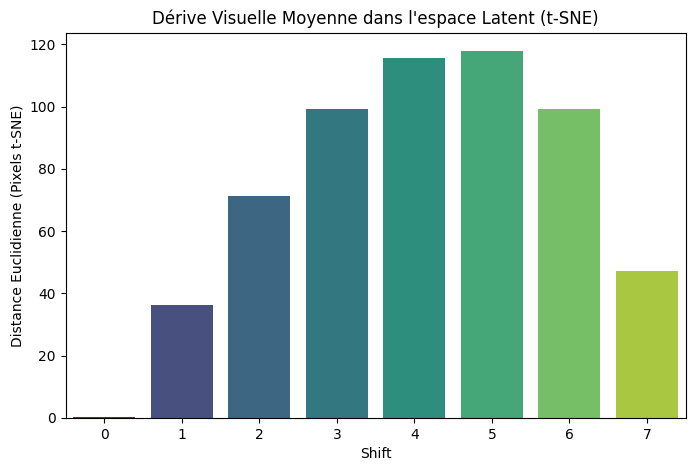

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Séparer les originaux des chiffrés
# On ne garde que ID et coordonnées pour les originaux
df_orig = plot_df[plot_df['Type'] == 'Original'][['Image_ID', 'tsne_1', 'tsne_2']]
df_enc = plot_df[plot_df['Type'] == 'Chiffre']

# 2. Fusionner pour avoir les coordonnées (Orig, Chiffre) sur la même ligne
# On joint sur 'Image_ID'
merged_df = pd.merge(
    df_enc, 
    df_orig, 
    on='Image_ID', 
    suffixes=('_enc', '_orig')
)

# 3. Calcul de la Distance Euclidienne (Visual Drift)
# d = sqrt((x2-x1)^2 + (y2-y1)^2)
merged_df['visual_distance'] = np.sqrt(
    (merged_df['tsne_1_enc'] - merged_df['tsne_1_orig'])**2 + 
    (merged_df['tsne_2_enc'] - merged_df['tsne_2_orig'])**2
)

# 4. Moyenne par Shift
avg_drift = merged_df.groupby('Shift')['visual_distance'].mean().reset_index()

print("Distance moyenne sur le graphique t-SNE par Shift :")
print(avg_drift)

# 5. Visualisation de la métrique
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_drift, x='Shift', y='visual_distance', palette="viridis")
plt.title("Dérive Visuelle Moyenne dans l'espace Latent (t-SNE)")
plt.ylabel("Distance Euclidienne (Pixels t-SNE)")
plt.show()

a voir dans lespace latent


Similitude Sémantique (Cosine) Moyenne par Shift :
  Shift  Cosine_Similarity
0     0           1.000000
1     1           0.736478
2     2           0.607158
3     3           0.525965
4     4           0.491916
5     5           0.489202
6     6           0.554061
7     7           0.721494


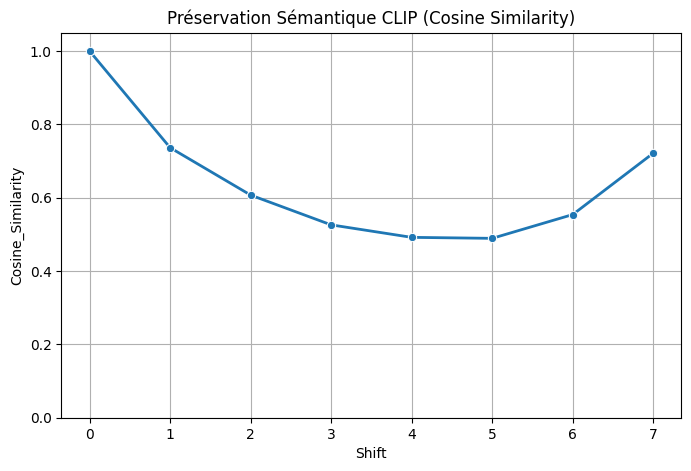

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

df_vecs = pd.DataFrame({
    'Image_ID': labels_id,
    'Type': labels_type,
    'Shift': labels_shift,
    'Index_X': range(len(labels_id)) # Pour retrouver la ligne dans X
})

results_cos = []

# Pour chaque image unique
unique_ids = df_vecs['Image_ID'].unique()

for img_id in unique_ids:
    # Récupérer l'index du vecteur Original
    idx_orig = df_vecs[(df_vecs['Image_ID'] == img_id) & (df_vecs['Type'] == 'Original')]['Index_X'].values
    
    if len(idx_orig) > 0:
        idx_orig = idx_orig[0]
        vec_orig = X[idx_orig].reshape(1, -1) # Format (1, 512)
        
        # Récupérer les vecteurs chiffrés pour cette image
        sub_df = df_vecs[(df_vecs['Image_ID'] == img_id) & (df_vecs['Type'] == 'Chiffre')]
        
        for _, row in sub_df.iterrows():
            idx_enc = row['Index_X']
            shift_val = row['Shift']
            vec_enc = X[idx_enc].reshape(1, -1)
            
            # Calcul Cosine Similarity (de -1 à 1)
            # 1.0 = Identique, 0.0 = Orthogonal, -1.0 = Opposé
            sim = cosine_similarity(vec_orig, vec_enc)[0][0]
            
            results_cos.append({
                'Image_ID': img_id,
                'Shift': shift_val,
                'Cosine_Similarity': sim
            })

# Agrégation
df_sim = pd.DataFrame(results_cos)
avg_sim = df_sim.groupby('Shift')['Cosine_Similarity'].mean().reset_index()

print("\nSimilitude Sémantique (Cosine) Moyenne par Shift :")
print(avg_sim)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=avg_sim, x='Shift', y='Cosine_Similarity', marker='o', linewidth=2)
plt.title("Préservation Sémantique CLIP (Cosine Similarity)")
plt.ylim(0, 1.05) # L'échelle va de 0 à 1
plt.grid(True)
plt.show()

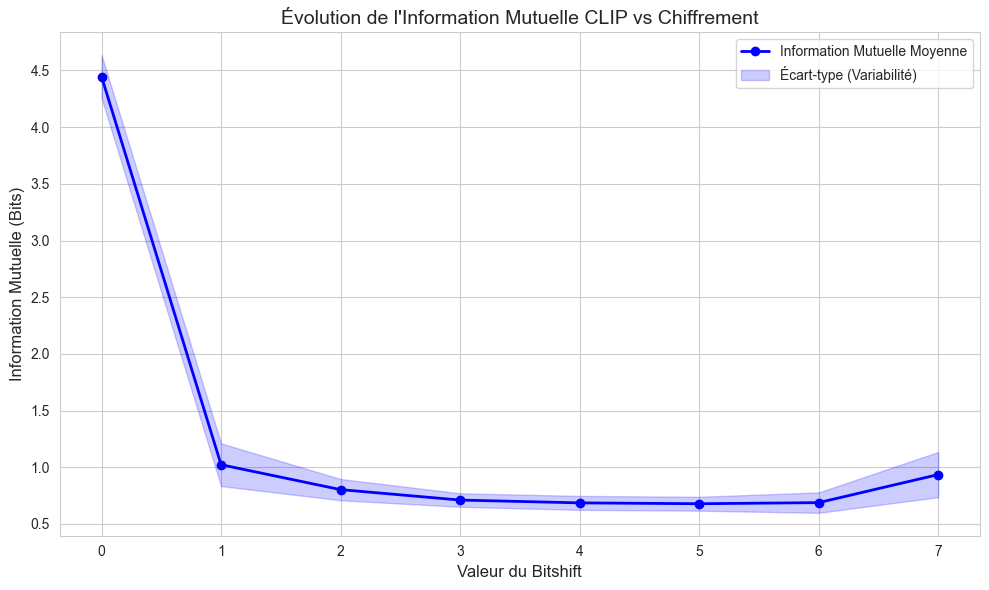

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_mi_evolution(summary_data):
    # 1. Conversion en DataFrame (si ce n'est pas déjà fait)
    if isinstance(summary_data, list):
        df = pd.DataFrame(summary_data)
    else:
        df = summary_data.copy()
        
    # S'assurer que les données sont triées par Shift pour que la ligne ne fasse pas des zig-zags
    df = df.sort_values('shift')

    # 2. Configuration du style
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    # 3. Tracé de la courbe moyenne
    # On utilise 'marker' pour bien voir les points de mesure
    plt.plot(df['shift'], df['mi_mean'], 
             color='blue', marker='o', linewidth=2, label='Information Mutuelle Moyenne')

    # 4. Tracé de l'écart-type (Zone ombrée)
    # Cela représente la variabilité de la MI d'une image à l'autre
    plt.fill_between(df['shift'], 
                     df['mi_mean'] - df['mi_std'], 
                     df['mi_mean'] + df['mi_std'], 
                     color='blue', alpha=0.2, label='Écart-type (Variabilité)')

    # 5. Esthétique
    plt.title("Évolution de l'Information Mutuelle CLIP vs Chiffrement", fontsize=14)
    plt.xlabel("Valeur du Bitshift", fontsize=12)
    plt.ylabel("Information Mutuelle (Bits)", fontsize=12)
    plt.legend()
    
    # Optionnel : Forcer l'axe X à n'afficher que les entiers si peu de shifts
    if len(df) < 20:
        plt.xticks(df['shift'])

    plt.tight_layout()
    plt.show()

# --- UTILISATION ---
# Appelle la fonction avec ta liste summary_data ou ton DataFrame df_summary
plot_mi_evolution(df_final)

KeyError: 'Column not found: mi_mine'

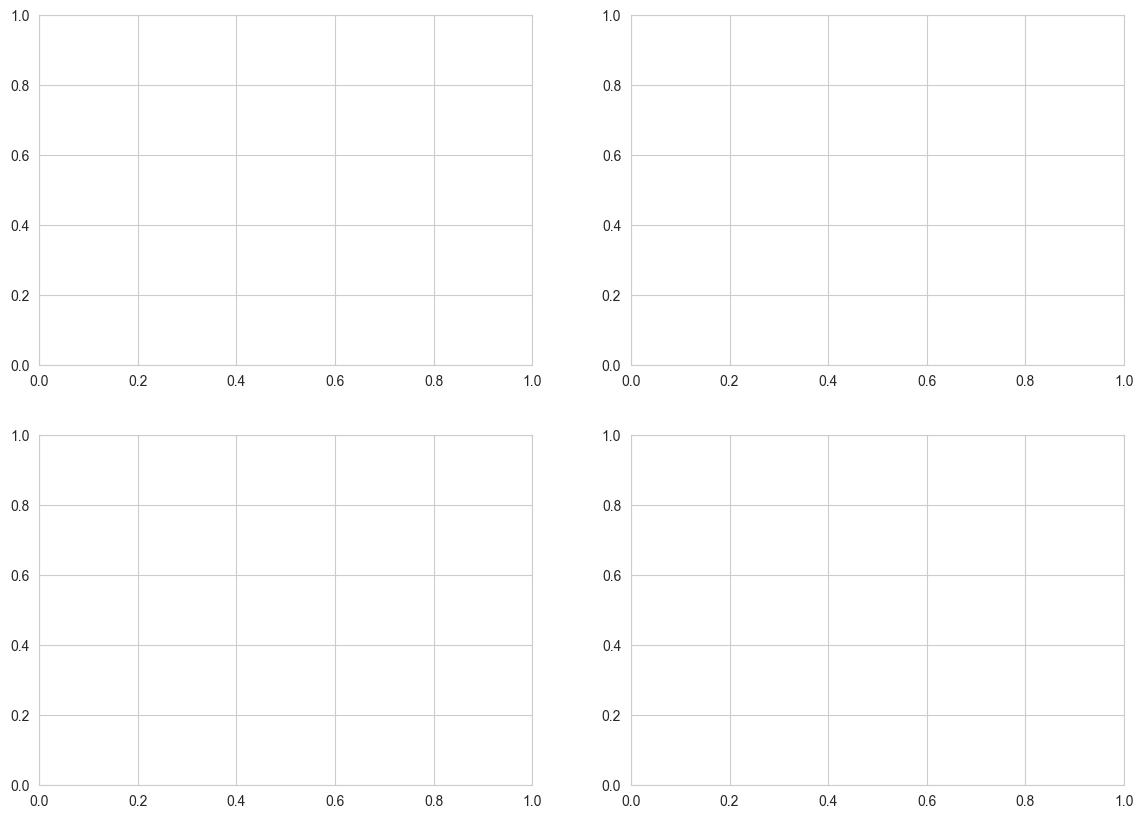

In [ ]:
def plot_results(df_results):
    """
    Crée des visualisations des résultats.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    '''
    # 1. MI Histogram vs Shift
    grouped = df_results.groupby('shift')['mi_histogram'].agg(['mean', 'std'])
    axes[0, 0].errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                        marker='o', capsize=5)
    axes[0, 0].set_xlabel('Shift')
    axes[0, 0].set_ylabel('MI Histogramme')
    axes[0, 0].set_title('Information Mutuelle (Histogramme) vs Shift')
    axes[0, 0].grid(True, alpha=0.3)
    '''
    # 2. MI MINE vs Shift
    grouped_mine = df_results.groupby('shift')['mi_mine'].agg(['mean', 'std'])
    axes[0, 1].errorbar(grouped_mine.index, grouped_mine['mean'], 
                        yerr=grouped_mine['std'], marker='s', capsize=5, color='orange')
    axes[0, 1].set_xlabel('Shift')
    axes[0, 1].set_ylabel('MI MINE')
    axes[0, 1].set_title('Information Mutuelle (MINE) vs Shift')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Entropie moyenne
    entropy_mean = df_results.groupby('shift')['entropy_original'].mean().iloc[0]
    axes[1, 0].axhline(y=entropy_mean, color='green', linestyle='--', 
                       label=f'Entropie moyenne: {entropy_mean:.2f}')
    axes[1, 0].set_title('Entropie Originale (Constante)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    '''
    # 4. Comparaison (Version améliorée)
    scatter = axes[1, 1].scatter(df_results['mi_histogram'], df_results['mi_mine'], 
                        alpha=0.6, c=df_results['shift'], cmap='viridis', edgecolors='w', s=60)

    axes[1, 1].set_xlabel('MI Histogramme')
    axes[1, 1].set_ylabel('MI MINE (échelle propre)')
    axes[1, 1].set_title('Corrélation entre MI Hist et MINE')
x    # Ajouter une colorbar pour comprendre que la couleur = shift
    plt.colorbar(scatter, ax=axes[1, 1], label='Shift')
    '''
    # Supprimer la ligne y=x qui écrase tout
    # Si vous voulez voir la tendance, ajoutez une régression linéaire simple :
    # m, b = np.polyfit(df_results['mi_histogram'], df_results['mi_mine'], 1)
    # axes[1, 1].plot(df_results['mi_histogram'], m*df_results['mi_histogram'] + b, 'r--', label='Tendance')

    axes[1, 1].grid(True, alpha=0.3, linestyle='--')

    # Laisser matplotlib ajuster les échelles automatiquement ou forcer légèrement :
    # axes[1, 1].autoscale(enable=True, axis='both', tight=True)
        
    plt.tight_layout()
    plt.savefig('results_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Graphiques sauvegardés dans 'results_analysis.png'")

# Visualiser
plot_results(df_final)